In [ ]:
import os
import time
from datetime import datetime

import getpass
import numpy as np
import pandas as pd
import xarray
from matplotlib import pyplot as plt

from maridatadownloader import DownloaderFactory

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
def absolute_file_paths(directory):
    for root, dirs, files in os.walk(directory):
        for f in files:
            yield os.path.abspath(os.path.join(root, f))

In [ ]:
position_files_folder = '<insert-path>'

In [ ]:
position_files = list(absolute_file_paths(position_files_folder))
position_files

In [ ]:
csv_file = position_files[0]

In [7]:
# Read csv
df_positions = pd.read_csv(csv_file, names=['time','latitude','N','longitude','E'], sep='\||,', dtype=str, engine='python')

# Parse coordinates
df_positions['latitude'] = df_positions['latitude'].map(lambda item: int(item[:2]) + float(item[2:])/60)
df_positions['longitude'] = df_positions['longitude'].map(lambda item: int(item[:3]) + float(item[3:])/60)
df_positions['time'] = df_positions['time'].map(lambda item: datetime.strptime(item, '%Y-%m-%dT%H:%M:%S.%f'))
df_positions.drop(columns=['N','E'], inplace=True)

# Create xarray.Dataset from pandas.Dataframe 
#ds_positions = df_positions.to_xarray().rename({'index': 'trajectory'}).set_coords(['time', 'latitude', 'longitude']).drop_vars('trajectory')

df_positions

,time,latitude,longitude
0,2023-08-09 01:17:39.046,44.438958,12.244237
1,2023-08-09 01:17:40.885,44.438958,12.244237
2,2023-08-09 01:17:43.974,44.438958,12.244237
3,2023-08-09 01:17:44.204,44.438958,12.244237
4,2023-08-09 01:17:46.113,44.438957,12.244237
...,...,...,...
20995,2023-08-09 10:57:20.052,44.438970,12.244205
20996,2023-08-09 10:57:23.340,44.438970,12.244205
20997,2023-08-09 10:57:24.470,44.438970,12.244205
20998,2023-08-09 10:57:24.660,44.438970,12.244205


In [ ]:
# Define parameters for enriching trajectory with environmental data
every_nth_row = 1

lons = df_positions.iloc[::every_nth_row]['longitude'].tolist()
lats = df_positions.iloc[::every_nth_row]['latitude'].tolist()
#times = df_positions.iloc[::every_nth_row]['time'].tolist()
times = [ts.to_pydatetime() for ts in df_positions.iloc[::every_nth_row]['time'].tolist()]

lons_xr = xarray.DataArray(lons, dims=['trajectory'])
lats_xr = xarray.DataArray(lats, dims=['trajectory'])
times_xr = xarray.DataArray(times, dims=['trajectory'])

# GFS (weather data)

In [ ]:
height = 10

parameters = ["Temperature_surface", "Pressure_reduced_to_MSL_msl", "Wind_speed_gust_surface", 
              "u-component_of_wind_height_above_ground", "v-component_of_wind_height_above_ground"]

sel_dict = {'time': times_xr, 'time1': times_xr, 'longitude': lons_xr, 'latitude': lats_xr, 
            'height_above_ground2': height}

In [ ]:
gfs = DownloaderFactory.get_downloader('opendap', 'gfs')

"ValueError: polynomial is not a valid interpolator for interpolating over multiple dimensions." <br>
-> for multiple dimensions only 'nearest' and 'linear' are supported

In [ ]:
%%time
# Subset data along trajectory using linear interpolation
dataset_gfs_trajectory_interp = gfs.download(parameters=parameters, sel_dict=sel_dict, interpolate=True)
dataset_gfs_trajectory_interp

In [ ]:
%%time
# Subset data along trajectory using nearest interpolation
dataset_gfs_trajectory_interp_nearest = gfs.download(parameters=parameters, sel_dict=sel_dict, interpolate=True, method='nearest')
dataset_gfs_trajectory_interp_nearest

In [ ]:
%%time
# Subset data along trajectory using inexact matches
dataset_gfs_trajectory_inexact = gfs.download(parameters=parameters, sel_dict=sel_dict, interpolate=False, method='nearest')
dataset_gfs_trajectory_inexact

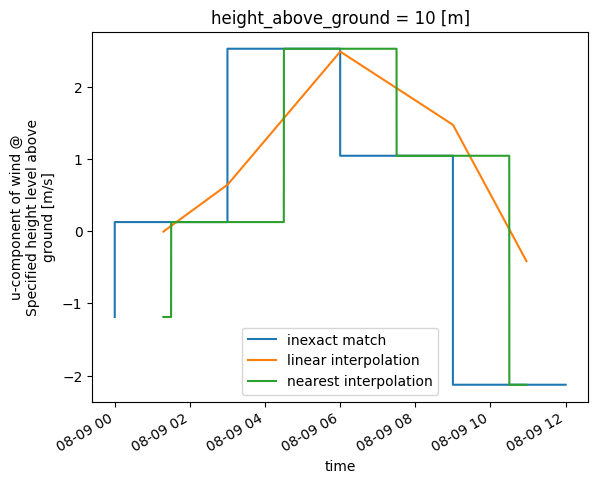

In [13]:
# Plot comparison
dataset_gfs_trajectory_inexact['u-component_of_wind_height_above_ground'].plot.step(x='time', label="inexact match");
dataset_gfs_trajectory_interp['u-component_of_wind_height_above_ground'].plot(x='time', label="linear interpolation");
dataset_gfs_trajectory_interp_nearest['u-component_of_wind_height_above_ground'].plot(x='time', label="nearest interpolation");
plt.legend(loc="lower center");

# CMEMS

In [ ]:
username = '<username>'
password = getpass.getpass('Enter your password: ')

In [ ]:
sel_dict = {'time': times_xr, 'longitude': lons_xr, 'latitude': lats_xr}

In [ ]:
def check_nan_values(data_array):
    assert type(data_array) == xarray.DataArray
    number_nans = (np.isnan(data_array)).sum().values
    number_non_nans = (~np.isnan(data_array)).sum().values
    if number_nans > 0:
        print("!!! Warning: NaN values detected !!!")
    print("Number of nan values (nans):", number_nans)
    print("Number of no nan values (nonans):", number_non_nans)
    print("Total number of values (nans + nonans):", number_nans + number_non_nans)
    print("---------------------")
    if 'trajectory' in data_array.dims:
        assert len(data_array.trajectory) == len(data_array.latitude) == len(data_array.longitude) == len(data_array.time)
        print("Total number of points in trajectory:", len(data_array.trajectory))
    else:
        print("Number of latitudes (lats):", len(data_array.latitude))
        print("Number of longitudes (lons):", len(data_array.longitude))
        if 'time' in data_array.coords:
            print("Number of times (times):", len(data_array.time))
            print("Total number of points (lats * lons * time):", 
                  len(data_array.latitude) * len(data_array.longitude) * len(data_array.time))
            print("(lats * lons * times) - (sum nans + no nans):",
                  len(data_array.latitude) * len(data_array.longitude) * len(data_array.time) - number_nans - number_non_nans)
        else:
            print("Total number of points (lats * lons):", len(data_array.latitude) * len(data_array.longitude))
            print("(lats * lons) - (sum nans + no nans):", 
                  len(data_array.latitude) * len(data_array.longitude) - number_nans - number_non_nans)

## Wave data 

In [ ]:
product = 'cmems_mod_glo_wav_anfc_0.083deg_PT3H-i'  # nrt
product_type = 'nrt'

parameters = ["VHM0", "VMDR", "VTPK"]

In [ ]:
cmems = DownloaderFactory.get_downloader('opendap', 'cmems', username, password, 
                                         product=product, product_type=product_type)

In [ ]:
dataset_waves_trajectory = cmems.download(parameters=parameters, sel_dict=sel_dict, interpolate=True, method='nearest')
dataset_waves_trajectory

In [ ]:
for var in dataset_waves_trajectory.data_vars:
    print("########## Variable:", var, "##########")
    check_nan_values(dataset_waves_trajectory[var])

### Handle NaN values (e.g. route points close to coast) 

In [ ]:
# Create sub cube for efficiency
buffer_space = 1  # in degress

time_next_lower = cmems.dataset.time.sel(time=min(times), method='ffill')
time_next_upper = cmems.dataset.time.sel(time=max(times), method='bfill')

cmems_sub_cube = cmems.download(parameters=parameters, sel_dict={'time': slice(time_next_lower, time_next_upper)})
cmems_sub_cube = cmems_sub_cube.sel(latitude=slice(lats[0]-buffer_space, lats[-1]+buffer_space), 
                                    longitude=slice(lons[0]-buffer_space, lons[-1]+buffer_space))
cmems_sub_cube

### 1) Backward/forward fill approach

In [ ]:
# ffill = forward fill, bfill = backward fill
# Note that changing the order changes the result
fill_limit = 1  # in pixels

cmems_sub_cube_corrected = cmems_sub_cube.ffill(dim='longitude', limit=fill_limit).bfill(dim='longitude', limit=fill_limit)
cmems_sub_cube_corrected = cmems_sub_cube_corrected.ffill(dim='latitude', limit=fill_limit).bfill(dim='latitude', limit=fill_limit)
cmems_sub_cube_corrected

### 2) Extrapolation approach

In [ ]:
extrapolation_method = 'linear'

cmems_sub_cube_corrected = cmems_sub_cube.interpolate_na(dim="longitude", use_coordinate="longitude", fill_value="extrapolate", method=extrapolation_method)
cmems_sub_cube_corrected = cmems_sub_cube_corrected.interpolate_na(dim="latitude", use_coordinate="latitude", fill_value="extrapolate", method=extrapolation_method)
cmems_sub_cube_corrected

In [ ]:
# Check difference
diff_orig_corrected = cmems_sub_cube[var].isel(time=time_idx)-cmems_sub_cube_corrected[var].isel(time=time_idx)
np.unique(diff_orig_corrected)

In [ ]:
var = 'VHM0'
time_idx = 0

fig, axs = plt.subplots(ncols=2, figsize=(10,4))
cmems_sub_cube[var].isel(time=time_idx).plot(ax=axs[0])
cmems_sub_cube_corrected[var].isel(time=time_idx).plot(ax=axs[1]);

In [ ]:
dataset_waves_trajectory = cmems_sub_cube_corrected.interp(**sel_dict, method='nearest')
dataset_waves_trajectory

In [ ]:
for var in dataset_waves_trajectory.data_vars:
    print("########## Variable:", var, "##########")
    check_nan_values(dataset_waves_trajectory[var])

In [ ]:
fig, axs = plt.subplots(ncols=len(dataset_waves_trajectory.data_vars), figsize=(12,4))
for idx, var in enumerate(dataset_waves_trajectory.data_vars):
    dataset_waves_trajectory[var].plot(ax=axs[idx])

# Combine everything into a single dataframe

In [ ]:
#tbd

In [ ]:
df_positions_env = dataset_gfs_trajectory_interp_nearest.to_dataframe()
df_positions_env